<img src="NotebookAddons/blackboard-banner.png" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657: Microwave Remote Sensing<b> </font>

<font size="5"> <b>Lab 9: InSAR Time Series Analysis using GIAnT within Jupyter Notebooks<br>Part 1: Data Download & Preprocessing from a SARVIEWS Import <font color='rgba(200,0,0,0.2)'> -- [## Points] </font> </b> </font>

<br>
<font size="4"> <b> Franz J Meyer, Joshua J C Knicely, Alex Lewandowski, Rowan Biessel; University of Alaska Fairbanks</b> <br>
<img src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" /><font color='rgba(200,0,0,0.2)'> <b>Due Date: </b>NONE</font>
</font>

<font size="3"> This Lab is part of the UAF course <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657: Microwave Remote Sensing</a>. This lab is divided into 3 parts: 1) data download and preprocessing, 2) GIAnT time series, and 3) a simple Mogi source inversion. The primary goal of this lab is to demonstrate how to download the requisite data, specifically interferograms, and preprocess them for use with the Generic InSAR Analysis Toolbox (<a href="http://earthdef.caltech.edu/projects/giant/wiki" target="_blank">GIAnT</a>) in the framework of *Jupyter Notebooks*.<br>

<b>Our specific objectives for this lab are to:</b>

- Download data using ASF tools: 
    - From a SARVIEWS subscription. 
- Pre-process data: 
    - Subset (crop) the data to an Area of Interest (AOI). 
    - Verify the quality of the data.
    - Cull data selection based on a timeframe and orbital characteristics. 
    - Reproject interferograms to a uniform UTM zone. 
    - Use TRAIN to remove static atmospheric effects related to surface elevation.
</font>

<br>
<font face="Calibri">

<font size="5"> <b> Target Description </b> </font>

<font size="3"> In this lab, we will download interferograms covering a SARVIEWS area of interest.  </font>

<font size="4"> <font color='rgba(200,0,0,0.2)'> <b>THIS NOTEBOOK INCLUDES NO HOMEWORK ASSIGNMENTS.</b></font> <br>

Contact me at fjmeyer@alaska.edu should you run into any problems.
</font>

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/train':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "train" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "train" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "train" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

<font face='Calibri'><font size='5'><b>Overview</b></font>
<br>
<font size='3'><b>About TRAIN</b>
<br>
The tropospheric correction is one of the most significant challanges in InSAR. Without this correction, surface deformation signals can go completely unnoticed, or, perhaps worse, a false signal caused by the atmosphere can be taken as an accurate representation of surface deformation. This can often occur with volcanoes due to the characteristics of the atmosphere as well as the surface elevation (i.e., a taller point on the volcano means the InSAR signal passed through less atmosphere and will be affected differently from a point lower on the volcano). <br>We will use the Toolbox for Reducing Atmospheric InSAR Noise (TRAIN) today. The purpose of TRAIN is to add state of the art tropospheric correction methods to the InSAR processing chain. It can include corrections that are phase-based, using spectrometers, using weather models, and even data from balloon soundings. 
<br><br>
<b>Limitations</b>
<br>
The particular version we are using was created by the Alaska Satellite Facility. ASF took the original MATLAB code developed by David Bekaert created a Python2.7 wrapper (and more recently, a Python3.7 wrapper)for it. Currently, it only allows processing using MERRA2 data. Including other data types can be done relatively easily, though it does require modification of the existing python code. 
<br>
Each of the correction methods included in TRAIN is ideal for different locations and conditions. Spectrometers provide the best correction, but can only be used in cloud-free and daylight conditions. Phase-based and weather model correction methods capture regional signals well, but fail to capture turbulent tropospheric signals. 
<br><br>
More information about TRAIN, its capabilities, and its limitations can be found in <a href="http://www.sciencedirect.com/science/article/pii/S0034425715301231">Bekaert et al. [2015]</a>, at David Dekaert's <a href="http://davidbekaert.com/#links">webpage</a>, or at the <a href="https://github.com/asfadmin/hyp3-TRAIN" target="_blank">ASF Github</a>. 
<br><br>
<b>Steps to use TRAIN</b><br>

- System Setup
    - Import Python Packages
    - Set User Inputs
- Download and Preprocess Data
    - Access SARVIEWs Subscriptions
    - Download and unzip the Data
    - Project all Geotiffs to the Same UTM Zone
    - Mosaic Geotiffs with Partial Coverage
- Identify Area of Interest
- Subset (Crop) Data to Area of Interest
    - Subset the Data
    - Check that Subsetted Geotiffs have Pixels
    - Check the Dimensions of Subsetted Geotiffs
- Create Input Files and Code for TRAIN
    - Create <font face='Courier New'>parms_aps.txt</font> file
    - Create <font face='Courier New'>ifgday.mat</font> file
    - Convert Subsetted Tiffs to GCS Coordinates
    - Adjust file names
- Run TRAIN
    - Minor Set Up
    - Steps 0-3
    - Step 4
    - Comparison of Corrected and Uncorrected Unwrapped Phase
    - Convert back to the original coordinate system

<br><br>
When you use TRAIN, cite the creator's work using:<br>
Bekaert et al., RSE 2015, "Statistical comparison of InSAR tropospheric correction techniques." <br>&emsp;Open access: http://www.sciencedirect.com/science/article/pii/S0034425715301231
<!-- <br><br><b><i>DO WE NEED TO ALSO GIVE ASF A CITATION???</i></b> -->

<font face='Calibri'><font size='5'><b>0. Setup</b></font><br>
    <font size='3'>We will first import requisite Python libraries and modules, create or define an analysis directory, and define all of our user inputs. </font></font>

<font face='Calibri'>
<font size="4"> <b> 0.0 Import Python Packages and Enable Extensions</b></font>    <br>
    <font size='3'>First, we will import all needed libraries and modules. </font></font>

In [3]:
%%capture
import os
from getpass import getpass
import shutil
import re
import glob
import json
import pickle
import pathlib
from datetime import datetime, date
from copy import copy
from urllib.parse import urlparse, parse_qs

from osgeo import gdal
import pyproj
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import clear_output
from IPython.display import Markdown
plt.rcParams.update({'font.size': 12})

from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()

<font face='Calibri' size="4"> <b> 0.1 Define an Analysis Directory</b></font> 

In [4]:
while True:
    analysis_directory = input(f"\nPlease enter the name of a directory in which to store your data for this analysis.")
    if os.path.exists(analysis_directory):
        contents = glob.glob(f'{analysis_directory}/*')
        if len(contents) > 0:
            choice = asfn.handle_old_data(analysis_directory)
            if choice == 1:
                shutil.rmtree(analysis_directory)
                os.mkdir(analysis_directory)
                break
            if choice == 2:
                break
            else:
                clear_output()
                continue
        else:
            break
    else:
        os.mkdir(analysis_directory)
        break


Please enter the name of a directory in which to store your data for this analysis. test


<font face='Calibri' size="4"> <b> 0.2 Set Paths and TRAIN Parameters </b></font>   

<font face='Calibri'>
    <font size='3'><b>0.2.0 Create directories we will need later in the notebook</b><br></font>
</font>

In [5]:
os.chdir(analysis_directory)
analysis_directory = os.getcwd()
print(f"Current working directory: {analysis_directory}")

# Create a dictonary to hold values we wish to pickle and use in the Part 2 notebook
to_pickle = dict()

# Create the folder that will hold the full interferograms and their associated files. 
ingram_folder = 'ingrams'
pathlib.Path(ingram_folder).mkdir(parents=True, exist_ok=True)
to_pickle.update({'ingram_folder': ingram_folder})

# Create the folder in which we wish to store our interferogram subsets. 
subset_folder = 'ingram_subsets'
pathlib.Path(subset_folder).mkdir(parents=True, exist_ok=True)
to_pickle.update({'subset_folder': subset_folder})

            
# Create the folder in which we wish to store our converted interferogram subsets. 
# This is important later in the notebook when we convert our subsets from a 
# local geographic coordinate system to decimal degrees. 
corrected_folder = 'ingram_subsets_converted'
pathlib.Path(corrected_folder).mkdir(parents=True, exist_ok=True)
to_pickle.update({'corrected_folder': corrected_folder})


train_dir = '' # temporary blank directory
merra2_datapath = './MERRA2'
dem_path = os.path.join(train_dir,'myDEM.tif')

Current working directory: /home/jovyan/GEOS_657_Labs/2019/test


<font face='Calibri'>
    <font size='3'><b>0.2.1 Designate TRAIN Input Parameters</b><br></font>
</font>

In [6]:
era_data_type = 'ECMWF'
ifgday_file = 'ifgday.mat'
lambda_meters = 0.055465763 
incidence_angle = 38.5/180*np.pi # This needs to be in radians. 
extra = 0.1

<font face="Calibri" size="3"><b>Create a HyP3 object and authenticate</b> </font>

In [7]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  aflewandowski
NASA Earthdata Login password:  ··········


<hr>
<font face="Calibri">

<font size="5"> <b> 1. Download and Preprocess Data</b> </font>
    <br><br>
<font size="3"><b>1.0.1 List your projects and select one containing INSAR_GAMMA products:</b> </font>
<font>

In [8]:
my_hyp3_info = hyp3.my_info()
active_projects = dict()

for project in my_hyp3_info['job_names']:
    batch = Batch()
    batch = hyp3.find_jobs(name=project, job_type='INSAR_GAMMA').filter_jobs(running=False, include_expired=False)
    if len(batch) > 0:
        active_projects.update({batch.jobs[0].name: batch})

if len(active_projects) > 0:
    display(Markdown("<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>"))
    print('\nSelect a Project:')
    project_select = asfn.select_parameter(active_projects)
    display(project_select)
else:
    print("Found no projects containing active INSAR_GAMMA jobs")

<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>


Select a Project:


RadioButtons(layout=Layout(min_width='800px'), options={'La_Palma_2021': Batch([Job.from_dict({'job_id': 'ee85…

<font face="Calibri" size="3"><b>Select a date range of products to download:</b>
    <br><br>
Note: There may not yet be MERRA2 weather data for recently acquired scenes. Visit the <a href="https://disc.gsfc.nasa.gov/datasets?keywords=%22MERRA-2%20inst6_3d_ana_Np%22&page=1" target="_blank">MERRA2 inst6_3d_ana_Np dataset page</a> to confirm that you download HyP3 products that are old enough to have weather data. Avoid downloading products that are newer than the listed "End Date."</font>

In [9]:
batch = project_select.value

display(Markdown("<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>"))
print('\nSelect a Date Range:')
dates = asfn.get_job_dates(batch)
date_picker = asfn.gui_date_picker(dates)
date_picker

<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>


Select a Date Range:


SelectionRangeSlider(description='Dates', index=(0, 42), layout=Layout(width='500px'), options=((' 09/04/2021 …

<font face="Calibri" size="3"><b>Save the selected date range and remove products falling outside of it:</b> </font>

In [10]:
date_range = asfn.get_slider_vals(date_picker)
date_range[0] = date_range[0].date()
date_range[1] = date_range[1].date()
print(f"Date Range: {str(date_range[0])} to {str(date_range[1])}")
batch = asfn.filter_jobs_by_date(batch, date_range)

Date Range: 2021-09-04 to 2021-10-16


<font face="Calibri" size="3"><b>Gather the available paths and orbit directions for the remaining products:</b></font>

In [11]:
display(Markdown("<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>"))
asfn.set_paths_orbits(batch)
paths = set()
orbit_directions = set()
for p in batch:
    paths.add(p.path)
    orbit_directions.add(p.orbit_direction)
paths.add('All Paths')
display(Markdown(f"<text style=color:blue><text style='font-size:175%;'>Done.</text></text>"))

<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>

<text style=color:blue><text style='font-size:175%;'>Done.</text></text>

<font face="Calibri" size="3"><b>Select a path or paths (use shift or ctrl to select multiple paths):</b></font>

In [12]:
display(Markdown("<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Path:')
path_choice = asfn.select_mult_parameters(paths)
path_choice

<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>


Select a Path:


SelectMultiple(layout=Layout(height='38px', width='175px'), options=('169', 'All Paths'), value=())

<font face="Calibri" size="3"><b>Save the selected flight path/s:</b></font>

In [13]:
flight_path = path_choice.value
if flight_path:
    if flight_path:
        print(f"Flight Path: {flight_path}")
    else:
        print('Flight Path: All Paths')
else:
    print("WARNING: You must select a flight path in the previous cell, then rerun this cell.")

Flight Path: ('169',)


<font face="Calibri" size="3"><b>Select an orbit direction:</b></font>

In [14]:
if len(orbit_directions) > 1:
    display(Markdown("<text style='color:red;'>Note: After selecting a flight direction, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:red;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Flight Direction:')
direction_choice = asfn.select_parameter(orbit_directions, 'Direction:')
direction_choice


Select a Flight Direction:


RadioButtons(description='Direction:', layout=Layout(min_width='800px'), options=('DESCENDING',), value='DESCE…

<font face="Calibri" size="3"><b>Save the selected orbit direction:</b></font>

In [15]:
direction = direction_choice.value
print(f"Orbit Direction: {direction}")

Orbit Direction: DESCENDING


<font face="Calibri" size="3"><b>Filter jobs by path and orbit direction:</b></font>

In [16]:
batch = asfn.filter_jobs_by_path(batch, flight_path)
batch = asfn.filter_jobs_by_orbit(batch, direction)
print(f"There are {len(batch)} products to download.")

There are 13 products to download.


<font face="Calibri" size="3"><b>Download the products, unzip them into the rtc_products directory, and delete the zip files:</b> </font>

In [17]:
project_zips = batch.download_files(ingram_folder)
for z in project_zips:
    asfn.asf_unzip(ingram_folder, str(z))
    z.unlink()

  0%|          | 0/13 [00:00<?, ?it/s]

S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616.zip:   0%|          | 0/140363626 [00:00<?, ?it/s…

S1AA_20211004T071102_20211016T071102_VVP012_INT80_G_weF_1554.zip:   0%|          | 0/140056679 [00:00<?, ?it/s…

S1AA_20210922T071102_20211004T071102_VVP012_INT80_G_weF_693C.zip:   0%|          | 0/140199698 [00:00<?, ?it/s…

S1BA_20210904T071019_20210910T071102_VVP006_INT80_G_weF_8615.zip:   0%|          | 0/140452701 [00:00<?, ?it/s…

S1BB_20210904T071019_20210916T071020_VVP012_INT80_G_weF_E283.zip:   0%|          | 0/140520865 [00:00<?, ?it/s…

S1AB_20211004T071102_20211010T071020_VVP006_INT80_G_weF_D002.zip:   0%|          | 0/140124462 [00:00<?, ?it/s…

S1BB_20210916T071020_20210928T071020_VVP012_INT80_G_weF_E9DE.zip:   0%|          | 0/140114541 [00:00<?, ?it/s…

S1BA_20210928T071020_20211004T071102_VVP006_INT80_G_weF_DB90.zip:   0%|          | 0/140109873 [00:00<?, ?it/s…

S1BA_20210916T071020_20210922T071102_VVP006_INT80_G_weF_A130.zip:   0%|          | 0/140038487 [00:00<?, ?it/s…

S1BB_20210928T071020_20211010T071020_VVP012_INT80_G_weF_4B39.zip:   0%|          | 0/140149768 [00:00<?, ?it/s…

S1BA_20211010T071020_20211016T071102_VVP006_INT80_G_weF_DD78.zip:   0%|          | 0/140037003 [00:00<?, ?it/s…

S1AB_20210922T071102_20210928T071020_VVP006_INT80_G_weF_7569.zip:   0%|          | 0/140215027 [00:00<?, ?it/s…

S1AA_20210910T071102_20210922T071102_VVP012_INT80_G_weF_59B3.zip:   0%|          | 0/140295735 [00:00<?, ?it/s…

Extracting: ingrams/S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616.zip
Extracting: ingrams/S1AA_20211004T071102_20211016T071102_VVP012_INT80_G_weF_1554.zip
Extracting: ingrams/S1AA_20210922T071102_20211004T071102_VVP012_INT80_G_weF_693C.zip
Extracting: ingrams/S1BA_20210904T071019_20210910T071102_VVP006_INT80_G_weF_8615.zip
Extracting: ingrams/S1BB_20210904T071019_20210916T071020_VVP012_INT80_G_weF_E283.zip
Extracting: ingrams/S1AB_20211004T071102_20211010T071020_VVP006_INT80_G_weF_D002.zip
Extracting: ingrams/S1BB_20210916T071020_20210928T071020_VVP012_INT80_G_weF_E9DE.zip
Extracting: ingrams/S1BA_20210928T071020_20211004T071102_VVP006_INT80_G_weF_DB90.zip
Extracting: ingrams/S1BA_20210916T071020_20210922T071102_VVP006_INT80_G_weF_A130.zip
Extracting: ingrams/S1BB_20210928T071020_20211010T071020_VVP012_INT80_G_weF_4B39.zip
Extracting: ingrams/S1BA_20211010T071020_20211016T071102_VVP006_INT80_G_weF_DD78.zip
Extracting: ingrams/S1AB_20210922T071102_20210928T071020_VVP006_I

<font face="Calibri">
    <font size="5"> <b> 2. Prepare the Tiffs for Processing</b> </font>
</font>

<font face='Calibri'>
    <font size='4'><b>2.0 Gather Amplitude, Coherence, and Interferogram Paths</b></font><br><br>
    <font size='3'><b>2.0.0 Write functions to grab and print the path information for the amplitude, unwrapped phase, and the coherence files.</b></font>
</font>

In [18]:
def get_tiff_paths(paths):
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

def print_tiff_paths(tiff_paths):
    print("Tiff paths:")
    for p in tiff_paths:
        print(f"{p}\n")

<font face='Calibri' size='3'><b>2.0.1 Call the functions we just wrote to gather the file path information.</b></font>

In [19]:
amp_wild_path    = f"{ingram_folder}/*/*_amp.tif"
ingram_wild_path = f"{ingram_folder}/*/*_unw_phase.tif"
corr_wild_path   = f"{ingram_folder}/*/*_corr.tif"
amp_paths    = get_tiff_paths(amp_wild_path)
ingram_paths = get_tiff_paths(ingram_wild_path)
corr_paths    = get_tiff_paths(corr_wild_path)
# print(f"amp_path[0]: {amp_paths[0]}")
# print(f"ingram_path[0]: {ingram_paths[0]}")
# print(f"cohr_path[0]: {cohr_paths[0]}")

<font face='Calibri' size='3'><b>2.1.0 Write functions to filter product paths by orbit direction and file type</b>
</font>

In [20]:
def get_interferogram_headings(metadata_paths: list) -> dict:
    headings = {}
    for path in metadata_paths:
        with open(path, 'r') as metadata:
            for line in metadata:
                if 'Heading' in line:
                    headings.update({os.path.basename(path): float(line.split(':')[1])})
                    break
    return headings

<font face='Calibri' size='3'><b>2.1.1 Use heading directions from the product metadata to find the average heading and pickle it. <font>

In [21]:
# Create a list of paths to interferogram metadata
metadata_paths = []
for path in amp_paths:
    metadata_paths.append(path.replace('_amp.tif', '.txt'))
    
# Create a dictionary of interferogram headings 
# and find the average heading
headings = get_interferogram_headings(metadata_paths)
heading_avg = np.mean(list(headings.values()))
print(f'Average Heading: {heading_avg}')
to_pickle.update({'heading_avg': heading_avg})

Average Heading: 192.62619544615384


<font face='Calibri'><font size='4'><b>2.2 Project all data to the Same UTM Zone</b><br></font>
<font size='3'><font face='Calibri'><font size='3'>Some of the geotiffs may use different UTM zones. In the code below, we will identify the predominate UTM zone and reproject the rest into that zone. </font></font>

In [22]:
tiff_paths = amp_paths + ingram_paths + corr_paths
print_tiff_paths(tiff_paths)

Tiff paths:
ingrams/S1AA_20210910T071102_20210922T071102_VVP012_INT80_G_weF_59B3/S1AA_20210910T071102_20210922T071102_VVP012_INT80_G_weF_59B3_amp.tif

ingrams/S1AA_20210922T071102_20211004T071102_VVP012_INT80_G_weF_693C/S1AA_20210922T071102_20211004T071102_VVP012_INT80_G_weF_693C_amp.tif

ingrams/S1AA_20211004T071102_20211016T071102_VVP012_INT80_G_weF_1554/S1AA_20211004T071102_20211016T071102_VVP012_INT80_G_weF_1554_amp.tif

ingrams/S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616/S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616_amp.tif

ingrams/S1AB_20210922T071102_20210928T071020_VVP006_INT80_G_weF_7569/S1AB_20210922T071102_20210928T071020_VVP006_INT80_G_weF_7569_amp.tif

ingrams/S1AB_20211004T071102_20211010T071020_VVP006_INT80_G_weF_D002/S1AB_20211004T071102_20211010T071020_VVP006_INT80_G_weF_D002_amp.tif

ingrams/S1BA_20210904T071019_20210910T071102_VVP006_INT80_G_weF_8615/S1BA_20210904T071019_20210910T071102_VVP006_INT80_G_weF_8615_amp.tif

ingrams/S1BA_20

<font face="Calibri" size="3"><b>Reproject all tiffs to the predominate UTM:</b></font>

In [23]:
def get_utm_zones_types(tiff_paths):
    utm_zones = []
    utm_types = []
    print('Checking UTM Zones in the data stack ...\n')
    for i, path in enumerate(tiff_paths):
        info = (gdal.Info(path, options = ['-json']))
        info = json.dumps(info)
        info = (json.loads(info))['coordinateSystem']['wkt']
        zone = info.split('ID')[-1].split(',')[1][0:-2]
        utm_zones.append(zone)
        typ = info.split('ID')[-1].split('"')[1]
        utm_types.append(typ)
    return utm_zones, utm_types

utm_zones, utm_types = get_utm_zones_types(tiff_paths)
print(f"Unique UTM Zones: {list(set(utm_zones))}")
print(f"Unique UTM Types: {list(set(utm_types))}\n")

utm_unique, counts = np.unique(utm_zones, return_counts=True)
a = np.where(counts == np.max(counts))
predominant_utm = utm_unique[a][0]
print(f"Predominant UTM Zone: {predominant_utm}")
print(f"Number of UTM Zones:  {len(utm_unique)}")
to_pickle.update({'utm': predominant_utm})

Checking UTM Zones in the data stack ...

Unique UTM Zones: ['32627']
Unique UTM Types: ['EPSG']

Predominant UTM Zone: 32627
Number of UTM Zones:  1


In [24]:
reproject_indicies = [i for i, j in enumerate(utm_zones) if j != predominant_utm]
print('--------------------------------------------')
print('Reprojecting %4.1f files' %(len(reproject_indicies)))
print('--------------------------------------------')
for k in reproject_indicies:
    temppath = tiff_paths[k].strip()
    temppath = temppath.split('/')
    product_name = temppath[-2]
    tiff_name = temppath[-1]
    cmd = f"gdalwarp -overwrite {ingram_folder}/{product_name}/{tiff_name}"\
          f" {ingram_folder}/{product_name}/r{tiff_name} -s_srs {utm_types[k]}:"\
          f"{utm_zones[k]} -t_srs EPSG:{predominant_utm}"
    !$cmd
    rm_cmd = f"rm {tiff_paths[k].strip()}"
    !$rm_cmd

--------------------------------------------
Reprojecting  0.0 files
--------------------------------------------


<font face='Calibri'><font size='4'><b>2.3 Mosaic Geotiffs with Partial Coverage</b><br></font>
    <font size='3'>Merge multiple frames of the same type and from the same date into a single geotiff. This code makes the assumption that any imagery taken on the same day are frames that do not overlap the same areas. For Sentinel1 imagery, this holds true; for other data sources, it may not. </font></font>

<font face='Calibri'><font size='3'><b>2.3.0 Get the paths for the files to be merged.</b></font>

### TODO: revisit merging after we determine the correct criteria fro safely merging InSAR

In [25]:
#update paths after reprojecting

unw_wild_path  = f"{ingram_folder}/*/*_unw_phase.tif"

amp_paths    = get_tiff_paths(amp_wild_path)
corr_paths    = get_tiff_paths(corr_wild_path)
unw_paths  = get_tiff_paths(unw_wild_path)

<font face='Calibri'>
    <font size='5'> <b> 3. Subset Area of Interest</b> </font>
    <br>
    <font size='3'> Here we identify our area of interest (AOI). Our AOI must contain all of the expected deformation and a surrounding region of little to no deformation. Following our selection of this region, we will subset our data to this region. This helps reduce computation time. </font>
    <br><br>
    <font size='4'><b>3.0 Identify AOI</b></font> <br><br>
    <font size='3'><b>3.0.0 Update the paths to the amplitude data after merging in the previous section</b></font> 
</font>

In [26]:
# TODO: grab updated paths when merging is working

# amp_paths    = get_tiff_paths(amp_wild_path)
# corr_paths    = get_tiff_paths(corr_wild_path)
# unw_paths  = get_tiff_paths(unw_wild_path)

<font face='Calibri' size="3"> <b>3.0.1 Merge together one image from each area represented in the stack for display in the AOI selector:</b> </font> 

In [27]:
to_merge = {}
for pth in amp_paths:
    info = (gdal.Info(pth, options = ['-json']))
    info = json.dumps(info)
    info = (json.loads(info))['wgs84Extent']['coordinates']
    
    coords = [info[0][0], info[0][3]]
    for i in range(0, 2):
        for j in range(0, 2):
            coords[i][j] = round(coords[i][j])
    str_coords = f"{str(coords[0])}{str(coords[1])}"
    if str_coords not in to_merge:
        to_merge.update({str_coords: pth})
merge_paths = ""
for pth in to_merge:
    merge_paths = f"{merge_paths} {to_merge[pth]}"  
print(merge_paths)

full_scene = f"{analysis_directory}/full_scene.tif"
if os.path.exists(full_scene):
    os.remove(full_scene)
gdal_command = f"gdal_merge.py -o {full_scene} {merge_paths}"
print(gdal_command)
!{gdal_command}

 ingrams/S1AA_20210910T071102_20210922T071102_VVP012_INT80_G_weF_59B3/S1AA_20210910T071102_20210922T071102_VVP012_INT80_G_weF_59B3_amp.tif
gdal_merge.py -o /home/jovyan/GEOS_657_Labs/2019/test/full_scene.tif  ingrams/S1AA_20210910T071102_20210922T071102_VVP012_INT80_G_weF_59B3/S1AA_20210910T071102_20210922T071102_VVP012_INT80_G_weF_59B3_amp.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


<font face="Calibri" size="3"><b>3.0.2 Create a VRT (virtual raster stack) from merged images and convert that into array:</b> </font>

In [28]:
image_file = f"{analysis_directory}/raster_stack.vrt"
!gdalbuildvrt -separate $image_file -overwrite $full_scene

img = gdal.Open(image_file)
rasterstack = img.ReadAsArray()

0...10...20...30...40...50...60...70...80...90...100 - done.


<font face="Calibri" size="3"><b>3.0.3 Create an AOI selector from your raster stack:</b> </font>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
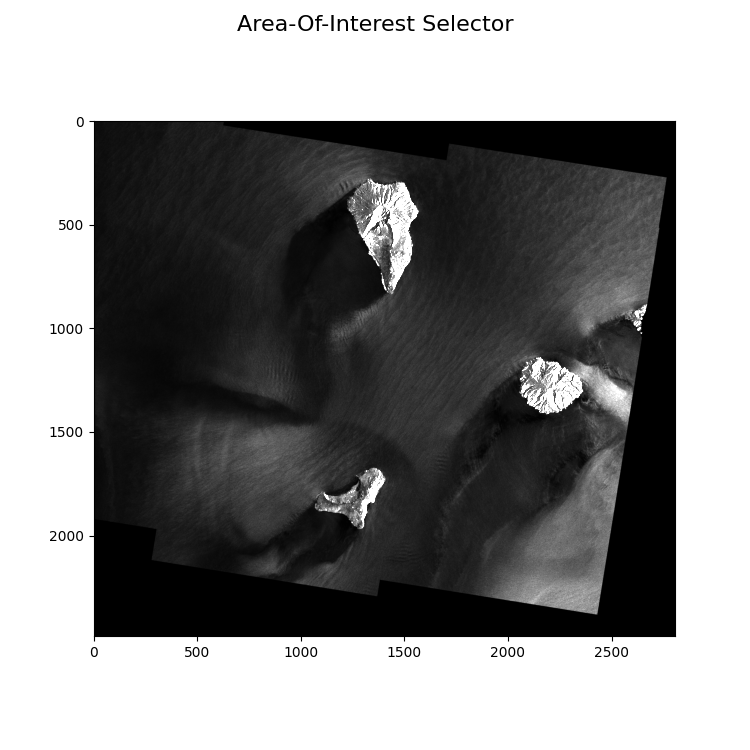

In [29]:
%matplotlib widget
fig_xsize = 7.5
fig_ysize = 7.5
aoi = asfn.AOI_Selector(rasterstack, fig_xsize, fig_ysize)

<font face="Calibri" size="3"><b>3.0.4 Gather and define projection details:</b> </font>

In [30]:
geotrans = img.GetGeoTransform()
projlatlon = pyproj.Proj('EPSG:4326') # WGS84
projimg = pyproj.Proj(f'EPSG:{predominant_utm}')

<font face="Calibri" size="3"><b>3.0.5 Write a function to convert the pixel, line coordinates from the AOI selector into geographic coordinates in the stack's EPSG projection:</b> </font>

In [31]:
def geolocation(x, y, geotrans,latlon=True):
    ref_x = geotrans[0]+x*geotrans[1]
    ref_y = geotrans[3]+y*geotrans[5]
    if latlon:
        ref_y, ref_x = pyproj.transform(projimg, projlatlon, ref_x, ref_y)
    return [ref_x, ref_y]

<font face="Calibri" size="3"><b>3.0.6 Call geolocation to gather the aoi_coords:</b> </font>

In [32]:
try:
    aoi_coords = [geolocation(aoi.x1, aoi.y1, geotrans, latlon=False), geolocation(aoi.x2, aoi.y2, geotrans, latlon=False)]
    print(f"aoi_coords in EPSG {predominant_utm}: {aoi_coords}")
except TypeError:
    print('TypeError')
    Markdown(f'<text style=color:red>This error occurs if an AOI was not selected.</text>')
    Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>')
    Markdown(f'<text style=color:red>Read the tips above the AOI selector carefully.</text>')

aoi_coords in EPSG 32627: [[780227.8602150538, 3203389.572043011], [838178.8279569892, 3142347.8860215056]]


<font face='Calibri' size='4'><b> 3.1 Subset (Crop) Data to Area of Interest </b> </font>
<br>
<font face='Calibri' size='3'>We now subset our data to our AOI. We must do this for both the interferograms and the coherence files. In this lab, we will also subset the amplitude image files for later display purposes, though this is not necessary.</font>

In [33]:
tiff_paths = amp_paths + unw_paths + corr_paths
print("Subsetting amplitude, coherence, and interferogram files.")
for p in tiff_paths:
    gdal_command = (f"gdal_translate -epo -eco -projwin {aoi_coords[0][0]} "
                    f"{aoi_coords[0][1]} {aoi_coords[1][0]} {aoi_coords[1][1]} "
                    f"-projwin_srs 'EPSG:{predominant_utm}' -co \"COMPRESS=DEFLATE\" "
                    f"-a_nodata 0 {p} {subset_folder}/{os.path.basename(p)} > /dev/null")

#     print(f"\nCalling the command: {gdal_command}") 
    !{gdal_command} # Call the GDAL command. 
print("Subsetting complete.")

Subsetting amplitude, coherence, and interferogram files.
Subsetting complete.


<font face='Calibri'><font size='4'><b>3.2 Perform some checks on the subset data</b></font>
<br>  
<font size='3'><b>3.2.0 Check that the Subsetted Tiffs have Pixels</b></font>
<br>
<font size='3'>Some of the subsetted geotiffs do not have pixels in our AOI despite the "-epo" and "-eco" options which should cause an error for all of these and skip them. Below, we will <b>check which geotiffs actually have pixels in our AOI and remove those that don't.</b> This can be done with a simple NaN search or by checking the band statistics of the file. </font>
</font>

In [34]:
subset_wild_path = f"{subset_folder}/*.tif"
subset_paths = get_tiff_paths(subset_wild_path)
asfn.remove_nan_filled_tifs(subset_paths) 

GeoTiffs Examined: 39
GeoTiffs Removed:  0


<font face='Calibri' size='3'><b>3.2.1 Check the dimensions of the subset tiffs</b>
<br>
In some instances, the gdal_translate function may return subset imagery with slightly different extents. They may differ in size by a single pixel width in the x or y dimension. This is usually only a problem when multiple data sensors are used. Sensors will often have different pixel sizes and/or their pixel locations will be slightly offset from each other. Since all of our data comes from Sentinel-1, we probably don't need to worry but it is still good to double check.</font>


In [35]:
subset_paths = get_tiff_paths(subset_wild_path)
subset_paths.sort()
print(f"Number of subset tifs: {len(subset_paths)}")
    
def get_pixels_lines(geotiff_paths: list) -> list:
    pixels = []
    lines = []
    for file in geotiff_paths:
        img = gdal.Open(file)
        pixels.append(img.RasterXSize)
        lines.append(img.RasterYSize)
    return {'pixels': set(pixels), 'lines': set(lines)}


dimensions = get_pixels_lines(subset_paths)
print(f"Dimensions: {dimensions}")
if len(dimensions['pixels']) > 1 or len(dimensions['lines']) > 1:
    print("Error: Not all subset images in stack have the same dimensions")
else:
    print("Check successful. All subset images in stack have the same dimensions.")

Number of subset tifs: 39
Dimensions: {'pixels': {724}, 'lines': {763}}
Check successful. All subset images in stack have the same dimensions.


<font face='Calibri'>
<font size='5'> <b> 4. Create Input Files and Code for TRAIN </b> </font>
<br>
<font size='3'> In this section, we will use TRAIN to remove static atmospheric effects that can cause decoherence of the interferograms. This primarily corrects for effects caused by elevation differences between locations. <br>If we think of the propogating radar wave as a set of discrete rays, each ray will follow a different path. Those that reflect from elevated locations will pass through less of the atmosphere and therefore be less altered than those rays that reflect from locations at lower elevations. Without this correction, interferograms often produce exaggerated deformation. This is especially important in hazard monitoring of active volcanoes as a false alarm can be extremely costly and cause the general public to ignore future warnings. 
</font>
    
</font>

<font face='Calibri'>
    <font size='3'>Let's create the input files and modify the files as required by TRAIN. The necessary items and actions are listed below. <br>
        
- parms_aps.txt
    - List of parameters defining how TRAIN will run.
- ifgday.txt
    - Text file listing the primary and secondary date pairs. 
    - 2 column vector [primary secondary]
    - Format: YYYYMMDD
- Convert subsetted '.tif' Files to GCS Coordinates
    - TRAIN requires the input '.tif' files to have a global coordinate system. 
    - We will convert them to EPSG:4326. 
- Adjust File Names
    - Many SAR codes expect the input files to have a particular name format. 
    - For TRAIN, this is <font face='Courier New'>&lt;primary\_date&gt;\_&lt;secondary\_date&gt;\_&lt;unwrapped, amplitude, or coherence designation&gt;.tif</font>.
<br></font>
    </font>
    
<font face='Calibri'>
    <font size='4'> <b>4.0 Create parms_aps.txt file</b> </font>
    <br>
    <font size='3'>We will need to create the file 'parms_aps.txt'. TRAIN will read parameters from this file. We will first need to extract some information from the satellite metadata files. We'll start with getting the UTC time of the satellite pass over our study area. <br>
        
</font>
    </font>
    
    
<font face='Calibri'>
<font size='3'><b>4.0.0 Extract the UTC Time</b>
<br>
This information is contained in the file name.<br>
Alternatively, it can be found in the metadata file named <font face='Courier New'>$<$primary timestamp$>$_$<$secondary timestamp$>$.txt</font> that comes with the interferogram.
</font>

In [36]:
def getUTC_sat(paths):
    utc_hr = []
    utc_min = []
    utc_sec = []
    for p in paths:
        tstamp = asfn.date_from_product_name(p).split('_')[0].split('T')[1]
        utc_hr.append(int(tstamp[0:2]))
        utc_min.append(int(tstamp[2:4]))
        utc_sec.append(int(tstamp[4:6]))    
    
    # UTC time as HH:MIN; we extract the median value and pad with up to 2 zeroes. 
    utc_sat = (f"{str(int(np.median(utc_hr))).zfill(2)}:"
               f"{str(int(np.median(utc_min))).zfill(2)}")
    # UTC time as an integer; Method from Tom Logan's prepGIAnT code
    # Can also be found inside <date>_<date>.txt file and hard coded/extracted
    c_l_utc = np.median(utc_hr)*3600 + np.median(utc_min)*60 + np.median(utc_sec) 
    return utc_sat, c_l_utc

unw_wild_path  = f"{subset_folder}/*_unw_phase.tif"
unw_paths = get_tiff_paths(unw_wild_path)

print("Unwrapped Phase Tifs:")
for file in unw_paths: 
    print(file)
    
utc_sat, c_l_utc = getUTC_sat(unw_paths)
print(f"\nUTC in int form: {c_l_utc}")
print(f"UTC in human-readable form: {utc_sat}")

Unwrapped Phase Tifs:
ingram_subsets/S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616_unw_phase.tif
ingram_subsets/S1AB_20210922T071102_20210928T071020_VVP006_INT80_G_weF_7569_unw_phase.tif
ingram_subsets/S1AB_20211004T071102_20211010T071020_VVP006_INT80_G_weF_D002_unw_phase.tif
ingram_subsets/S1BA_20210904T071019_20210910T071102_VVP006_INT80_G_weF_8615_unw_phase.tif
ingram_subsets/S1BA_20210916T071020_20210922T071102_VVP006_INT80_G_weF_A130_unw_phase.tif
ingram_subsets/S1BA_20210928T071020_20211004T071102_VVP006_INT80_G_weF_DB90_unw_phase.tif
ingram_subsets/S1BA_20211010T071020_20211016T071102_VVP006_INT80_G_weF_DD78_unw_phase.tif
ingram_subsets/S1AA_20210910T071102_20210922T071102_VVP012_INT80_G_weF_59B3_unw_phase.tif
ingram_subsets/S1AA_20210922T071102_20211004T071102_VVP012_INT80_G_weF_693C_unw_phase.tif
ingram_subsets/S1AA_20211004T071102_20211016T071102_VVP012_INT80_G_weF_1554_unw_phase.tif
ingram_subsets/S1BB_20210904T071019_20210916T071020_VVP012_INT80_G_weF_E283_un

<font face='Calibri'>
    <font size='3'><b>4.0.1 Create parms_aps.txt file</b> </font>
    <br>
    <font size='3'>Make the parms_aps.txt file. This gives TRAIN information on how to process the data. </font>
<br><br>
<font color='red'>Note: Ignore the deprecation warnings generated by this code cell. This is happening under-the-hood in pyproj's geopandas calls and will go away with future updates. It is a known issue, not something we can control, and will not impact results.</font>
    </font>

In [37]:
transformer = pyproj.Transformer.from_crs(f"epsg:{predominant_utm}", "epsg:4326")
llx, lly = transformer.transform(coords[0][0],coords[0][1])
urx, ury = transformer.transform(coords[1][0],coords[1][1])
region_lats = abs(np.diff([lly,ury])[0]) + extra
region_lons = abs(np.diff([llx,urx])[0]) + extra

!mkdir -p {merra2_datapath} # create the directory

parms_aps_Template = '''
# Input parameters for TRAIN

crop_flag: n
date_origin: file
dem_null: -32768
DEM_origin: asf
DEM_file: {7}
era_data_type: {1}
ifgday_file: {2}
incidence_angle: {9}
lambda: {8}
look_angle: 21
meric_perc_coverage: 80
merra2_datapath: {4}
non_defo_flag: n
region_lat_range: {5}
region_lon_range: {6}
region_res: 0.008333000000000
save_folder_name: aps_estimation
small_baseline_flag: n
stamps_processed: n
UTC_sat: {3}

'''

with open(os.path.join(train_dir,'parms_aps.txt'), 'w') as fid:
    fid.write(parms_aps_Template.format(train_dir, era_data_type,
                                        ifgday_file, utc_sat,
                                        merra2_datapath, region_lats,
                                        region_lons, dem_path,
                                        lambda_meters, incidence_angle))

<font face='Calibri'><font size='3'>You may notice that the <font face='Courier New'>parms_aps.txt</font> file we created has very little geographic information; we've only included the width and height of the subsetted interferograms in decimal degrees (the variables <font face='Courier New'>region_lats</font> and <font face='Courier New'>region_lons</font>). This is because we will use one of our subsetted and converted tiffs as a geographic reference file. Otherwise, we would need to create a text file that contains the latitude and longitude of each pixel in the interferogram.</font>
<br><br>  
<font face='Calibri'>
    <font size='4'><b>4.1 Create ifgday.mat file</b> </font>
    <br>
    <font size='3'>This gives TRAIN the primary and secondary dates of the interferograms as 2 column vectors. The dates must be separated by a single space.<br>
        
- Interferogram dates stored as a matrix with name ifgday and size [n_ifgs 2]. 
- Primary image is in the first and secondary is in the second column. 
- Specify dates as a numeric value in YYYYMMDD format.

    </font>
    </font>  

In [38]:
def dates_from_product_name(product_name: str) -> str:
    regex = "[0-9]{8}T[0-9]{6}_[0-9]{8}T[0-9]{6}"
    results = re.search(regex, product_name)
    if results:
        return results.group(0)
    else:
        return None

In [39]:
# Get all of the reference and secondary dates. 
ref_dates = []
sec_dates = []
for p in unw_paths:
    tstamps = dates_from_product_name(p) 
    ref_dates.append(tstamps.split('_')[0].split('T')[0])
    sec_dates.append(tstamps.split('_')[1].split('T')[0])
    
# Sort the dates according to the primary dates. 
ref_dates, sec_dates = (list(t) for t in zip(*sorted(zip(ref_dates, sec_dates))))

# write values to the 'ifgday_file'; make sure there is only 1 space between the dates.
with open( os.path.join(train_dir, ifgday_file), 'w') as ifg:
    for i, r_date in enumerate(ref_dates):
        ifg.write(f'{r_date} {sec_dates[i]}\n') 

# print the contents of the file we just wrote
with open(os.path.join(train_dir, ifgday_file),'r') as ifg:
    ifg_contents = ifg.read()
print(ifg_contents) 

20210904 20210910
20210904 20210916
20210910 20210916
20210910 20210922
20210916 20210922
20210916 20210928
20210922 20210928
20210922 20211004
20210928 20211004
20210928 20211010
20211004 20211010
20211004 20211016
20211010 20211016



<font face='Calibri'>
    <font size='4'><b>4.2 Convert Subsetted '.tif' Files to GCS Coordinates</b> </font>
    <br>
    <font size='3'>The ASF version of TRAIN requries our subsets to be in GCS coordinates (i.e., for every pixel in the subset to be designated by latitude and longitude). Currently, they are in a UTM coordinate system, which gives pixel location in meters based on a local coordinate system. We now will reproject our subsets to GCS.
</font>
<br><br>
<font face='Calibri' size='3'><b>4.2.0 Define the projection to which we will be reprojecting the subsets. This is typically designated as EPSG:4326.</b></font>

In [40]:
coord_TRAIN = '4326'

<font face='Calibri' size='3'><b>4.2.1 Create the converted subsets.</b></font>

In [41]:
for p in unw_paths:
    out_file = os.path.join(corrected_folder, os.path.basename(p))
    cmd = f"gdalwarp -t_srs EPSG:{coord_TRAIN} {p} {out_file}"
    !{cmd}

Creating output file that is 794P x 736L.
Processing ingram_subsets/S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616_unw_phase.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ingram_subsets/S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616_unw_phase.tif.
Copying nodata values from source ingram_subsets/S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616_unw_phase.tif to destination ingram_subsets_converted/S1AB_20210910T071102_20210916T071020_VVP006_INT80_G_weF_9616_unw_phase.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 794P x 736L.
Processing ingram_subsets/S1AB_20210922T071102_20210928T071020_VVP006_INT80_G_weF_7569_unw_phase.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ingram_subsets/S1AB_20210922T071102_20210928T071020_VVP006_INT80_G_weF_7569_unw_phase.tif.
Copying nodata values from source ingram_subsets/S1AB_20210922T071102_20210928T071020_VVP006_INT80_G_weF_7569_unw_phas

<font face='Calibri'>
    <font size='4'><b>4.3 Adjust File Names</b></font>
    <font size='3'><br>TRAIN expects the file naming format, <font face='Courier New'>&lt;reference_date&gt;_&lt;secondary_date&gt;_&lt;unwrapped, amplitude, or coherence designation&gt;.tif</font>. We will adjust the files to match this name convention. The code below assumes that the files all come from Sentinel-1 and that every interferogram has a unique primary and secondary date pair. <br><b>This is not always true; some interferograms will have identical primary/secondary date pairs, but have been taken at different times.</b> This is a relatively rare occurrence, but it is good to keep in mind. To keep this exercise relatively simple, we assume each interferogram has a unique primary/secondary date pair.</font>
<br><br>
<b>4.3.0 Write a function to rename the files</b>
</font>

In [42]:
def rename_files_for_train(data_dir, paths): 
    for p in paths:
        tstamps = dates_from_product_name(p) 
        ref_date = tstamps.split('_')[0].split('T')[0]
        sec_date = tstamps.split('_')[1].split('T')[0]
        if "_unw" in p:
            new_name = f"{ref_date}_{sec_date}_unw_phase.tif"
        elif "_corr" in p:
            new_name = f"{ref_date}_{sec_date}_corr.tif"
        elif "_amp" in p:
            new_name = f"{ref_date}_{sec_date}_amp.tif"
        
        exists = os.path.isfile(os.path.join(data_dir, new_name))
        if exists:
            print(f"File already exists: {new_name}")
        else:
            os.rename(os.path.join(data_dir, p),
                      os.path.join(data_dir, new_name))
    print("Files renamed.")
    return

<font face='Calibri' size='3'><b>4.3.1 Rename the subset files and save a list of the new filenames.</b></font>

In [43]:
files = [f for f in os.listdir(subset_folder) if f.endswith('.tif')] 
files.sort()

rename_files_for_train(subset_folder, files)
files_subset = [ f for f in os.listdir(subset_folder) ]

Files renamed.


<font face='Calibri' size='3'><b>4.3.2 Rename the converted files and save a list of the new filenames.</b></font>

In [44]:
files = [f for f in os.listdir(corrected_folder) if f.endswith('.tif')] 
files.sort()

rename_files_for_train(corrected_folder, files)
files_converted = [ f for f in os.listdir(corrected_folder) ] 

Files renamed.


<font face='Calibri'><font size='5'><b>5. Run TRAIN</b></font>
<br>
<font size='3'>We have now created all of the necessary files to run TRAIN. 
<br><br>
<font face='Calibri'><font size='4'><b>5.0 Minor Set Up</b></font>
<br>
<font size='3'>We have to set up some path information in order to run TRAIN. <i>Eventually, this will be modified so we don't have to include the full path to TRAIN.</i> Additionally, we show multiple ways in which to call TRAIN.</font></font>

In [45]:
train_path = "/home/jovyan/.local/TRAIN/src"
aps_weather_model_path = os.path.join(train_path,'aps_weather_model.py')
print(f"aps_weather_model.py path: {aps_weather_model_path}")
georef_path = os.path.join(analysis_directory, corrected_folder, files_converted[0])
print(f"\nPath to a georeference file: {georef_path}")

aps_weather_model.py path: /home/jovyan/.local/TRAIN/src/aps_weather_model.py

Path to a georeference file: /home/jovyan/GEOS_657_Labs/2019/test/ingram_subsets_converted/20210916_20210922_unw_phase.tif


In [46]:
!$train_path/aps_weather_model.py -h

usage: aps_weather_model [-h] [-g GEO_REF_FILE] sstep estep

Calcuate tropospheric (slant) delay for a stack of interferograms: 0 - Set up
list of weather data files to download; 1 - Download weather data; 2 -
Calculate wet and hydrostatic zenith delays; 3 - Calculate the SAR delays; 4 -
Subtract calculated delay from interferograms

positional arguments:
  sstep                 Start step to begin processing (0-4)
  estep                 End step to stop processing (0-4)

optional arguments:
  -h, --help            show this help message and exit
  -g GEO_REF_FILE, --geo_ref_file GEO_REF_FILE
                        Name of file for georeferencing information


<font face='Calibri'><font size='4'><b>5.1 TRAIN Steps 0-3</b></font>
    <br>
    <font size='3'>Now we run steps 0 through 3. Step 4 requires a few extra actions. 
    <br><br>
        <b>Step 0: Enter your Earthdata credentials</b>
        <br>
        TRAIN requires a .netrc holding your Earthdata credentials. To avoid permanently storing user secrets in OpenSARlab, we will create a .netrc, make a TRAIN call, and delete the .netrc, all in the same code cell.</font></font>

In [47]:
username = input("Enter your Earthdata username: ")
password = getpass("Enter your Earthdata password: ")
netrc_path = '/home/jovyan/.netrc'

def write_dot_netrc(path, username, password):
    with open(netrc_path, 'w+') as netrc:
        netrc.write(f'machine urs.earthdata.nasa.gov login {username} password {password}')

Enter your Earthdata username:  aflewandowski
Enter your Earthdata password:  ··········


<font face='Calibri' size='3'><b>Step 0: Identify weather data files to download.</b></font>

In [48]:
write_dot_netrc(netrc_path, username, password)

!$train_path/aps_weather_model.py -g {georef_path} 0 0

os.remove(netrc_path)

Starting run
Step 0: Determine files to download
Reading date_origin from file parms_aps.txt
Reading ifgday_file from file parms_aps.txt
Reading UTC_sat from file parms_aps.txt
Reading merra2_datapath from file parms_aps.txt
Reading region_lat_range from file /home/jovyan/GEOS_657_Labs/2019/test/ingram_subsets_converted/20210916_20210922_unw_phase.tif
Reading region_lon_range from file /home/jovyan/GEOS_657_Labs/2019/test/ingram_subsets_converted/20210916_20210922_unw_phase.tif
http://goldsmr5.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2Fs4pa%2FMERRA2%2FM2I6NPANA.5.12.4%2F2021%2F09%2FMERRA2_400.inst6_3d_ana_Np.20210904.nc4&FORMAT=bmM0Yy8&BBOX=26%2C-20%2C31%2C-16&TIME=1979-01-01T00%3A00%3A00%2F1979-01-01T00%3A00%3A00&LABEL=svc_MERRA2_400.inst6_3d_ana_Np.20210904.nc4&FLAGS=&SHORTNAME=M2I6NPANA&SERVICE=SUBSET_MERRA2&LAYERS=&VERSION=1.02&VARIABLES= 
http://goldsmr5.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2Fs4pa%2FMERRA2%2FM2I6NPA

<font face='Calibri' size='3'><b>Step 1: Download weather data.</b>
<br>
This will download a series of '*.nc4' files for each primary.</font>

In [49]:
# Delete any existing MERRA2 downloads to prevent old files from being used. 
try:
    shutil.rmtree(merra2_datapath)
except:
    pass

write_dot_netrc(netrc_path, username, password)

!$train_path/aps_weather_model.py -g {georef_path} 1 1

os.remove(netrc_path)

Starting run
Step 1: Order and download merra2 data files
Reading date_origin from file parms_aps.txt
Reading ifgday_file from file parms_aps.txt
Reading UTC_sat from file parms_aps.txt
Reading merra2_datapath from file parms_aps.txt
Reading region_lat_range from file /home/jovyan/GEOS_657_Labs/2019/test/ingram_subsets_converted/20210916_20210922_unw_phase.tif
Reading region_lon_range from file /home/jovyan/GEOS_657_Labs/2019/test/ingram_subsets_converted/20210916_20210922_unw_phase.tif
Running command: wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies  -O./MERRA2/20210904/MERRA2_20210904_00.nc4 "http://goldsmr5.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2Fs4pa%2FMERRA2%2FM2I6NPANA.5.12.4%2F2021%2F09%2FMERRA2_400.inst6_3d_ana_Np.20210904.nc4&FORMAT=bmM0Yy8&BBOX=26%2C-20%2C31%2C-16&TIME=1979-01-01T00%3A00%3A00%2F1979-01-01T00%3A00%3A00&LABEL=svc_MERRA2_400.inst6_3d_ana_Np.20210904.nc4&FLAGS=&SHORTN

<font face='Calibri' size='3'><b>Step 2: Calculate wet and hydrostatic zenith delays</b>
<br>
This will download a set of '*.xyz' files and use those 
to calculate the necessary delays.
<br><br>
Note: This step will error if the subset area being processed is too small. Unfortunately, the minimum area size does not appear to be documented. If you run into this issue, a little trial and error with subset sizes may be required. 
</font>

In [51]:
write_dot_netrc(netrc_path, username, password)

!$train_path/aps_weather_model.py -g {georef_path} 2 2

os.remove(netrc_path)

Starting run
Step 2: Compute the merra2 tropospheric (zenith) delay for individual dates
Reading merra2_datapath from file parms_aps.txt
Reading UTC_sat from file parms_aps.txt
Reading date_origin from file parms_aps.txt
Reading ifgday_file from file parms_aps.txt
Reading region_lat_range from file /home/jovyan/GEOS_657_Labs/2019/test/ingram_subsets_converted/20210916_20210922_unw_phase.tif
Reading region_lon_range from file /home/jovyan/GEOS_657_Labs/2019/test/ingram_subsets_converted/20210916_20210922_unw_phase.tif
Reading geotiff reference file; getting resolution.
Reading DEM_origin from file parms_aps.txt
Reading DEM_file from file parms_aps.txt
Creating DEM file myDEM.tif using the ASF DEM heap...
dem_list [['NED13', '4269'], ['SRTMGL1', '4326'], ['NED1', '4269'], ['NED2', '4269'], ['SRTMGL3', '4326']]
Reprojecting corners into projection 4269
Totals: ned13 0 0.3427775147410319 0.0
Totals: srtmgl1 0.34293409331398905 0.3427775147410532 1.0004567935941018
Best DEM: SRTMGL1
Tile Li

<font face='Calibri' size='3'><b>Step 3 - Calculate the SAR delays</b>
<br>
This produces *_*_{hydro_correction, wet_correction, and correction}.bin files
</font>

In [52]:
write_dot_netrc(netrc_path, username, password)

!$train_path/aps_weather_model.py -g {georef_path} 3 3

os.remove(netrc_path)

Starting run
Step 3: Compute merra2 tropospheric (slant) delay for inteferograms
Calculating phase delays
Reading merra2_datapath from file parms_aps.txt
Reading date_origin from file parms_aps.txt
Reading ifgday_file from file parms_aps.txt
Reading lambda from file parms_aps.txt
Reading incidence_angle from file parms_aps.txt
Using a single float value for incidence angle (0.6719517620178168)
Reading DEM_file from file parms_aps.txt
Reading file ./MERRA2/20210904/20210904_ZHD.xyz
Time to read and interpolate file 0.0
Reading DEM_file from file parms_aps.txt
Reading file ./MERRA2/20210904/20210904_ZWD.xyz
Time to read and interpolate file 0.0
Reading DEM_file from file parms_aps.txt
Reading file ./MERRA2/20210910/20210910_ZHD.xyz
Time to read and interpolate file 0.0
Reading DEM_file from file parms_aps.txt
Reading file ./MERRA2/20210910/20210910_ZWD.xyz
Time to read and interpolate file 0.0
Reading DEM_file from file parms_aps.txt
Reading file ./MERRA2/20210916/20210916_ZHD.xyz
Time t

<font face='Calibri'><font size='3'>Step 3 may give a strange message: "No correction for &lt;insert date&gt;". If this occurs, it is most likely because TRAIN wasn't able to access the MERRA2 files due to missing permissions in your Earthdata user account. This can be done by going to your <a href="https://urs.earthdata.nasa.gov/profile" target="_blank">EarthData's profile page</a>, clicking <b>Applications</b> and selecting <b>Approved Applications</b> from the drop down menu. Select <b>Approve More Applications</b> at the bottom left, search for <b>NASA GESDISC DATA ARCHIVE</b>, select it, and agree to the terms and conditions. Once that is complete, restart the kernel in the kernel menu and rerun the notebook.</font></font>   

<font face='Calibri'><font size='4'><b>5.2 TRAIN Step 4</b></font>
<br>
<font size='3'>In step 4, we apply the correction to our <font face='Courier New'>&lt;\*\_\*\_unw\_phase.tif&gt;</font> files. 
<br><br>
For this step, we need to do 2 things first:
<ol>
<li>Move all of the '*.bin' files into the same directory as our converted geotiffs.</li>
<li>Move into the converted geotiffs directory.</li>
</ol>
<b>5.2.0 Create a list of our .bin files</b></font>     

In [53]:
bin_paths = glob.glob("*.bin")
bin_paths.sort()
print(bin_paths)

['20210904_20210910_correction.bin', '20210904_20210910_hydro_correction.bin', '20210904_20210910_wet_correction.bin', '20210904_20210916_correction.bin', '20210904_20210916_hydro_correction.bin', '20210904_20210916_wet_correction.bin', '20210910_20210916_correction.bin', '20210910_20210916_hydro_correction.bin', '20210910_20210916_wet_correction.bin', '20210910_20210922_correction.bin', '20210910_20210922_hydro_correction.bin', '20210910_20210922_wet_correction.bin', '20210916_20210922_correction.bin', '20210916_20210922_hydro_correction.bin', '20210916_20210922_wet_correction.bin', '20210916_20210928_correction.bin', '20210916_20210928_hydro_correction.bin', '20210916_20210928_wet_correction.bin', '20210922_20210928_correction.bin', '20210922_20210928_hydro_correction.bin', '20210922_20210928_wet_correction.bin']


<font face='Calibri' size='3'><b>5.2.1 Move the .bin files into the converted geotiffs directory and then move into that directory</b></font> 

In [54]:
for p in bin_paths:
    try:
        shutil.move(p, os.path.join(corrected_folder, p))
    except FileNotFoundError:
        print(f"\nError, {p} does not exist.")
        print("Have you already moved your .bin files?")
        break

#TRAIN does not allow you to pass a path to the .bin files, so we must change directories
try:        
    os.chdir(f"{analysis_directory}/{corrected_folder}")
except FileNotFoundError:
    raise

<font face='Calibri' size='3'><b>5.2.2 Step 4 - Subtract calculated delay from interferograms</b></font>

In [55]:
!ls

20210904_20210910_correction.bin	20210916_20210922_hydro_correction.bin
20210904_20210910_hydro_correction.bin	20210916_20210922_unw_phase.tif
20210904_20210910_unw_phase.tif		20210916_20210922_wet_correction.bin
20210904_20210910_wet_correction.bin	20210916_20210928_correction.bin
20210904_20210916_correction.bin	20210916_20210928_hydro_correction.bin
20210904_20210916_hydro_correction.bin	20210916_20210928_unw_phase.tif
20210904_20210916_unw_phase.tif		20210916_20210928_wet_correction.bin
20210904_20210916_wet_correction.bin	20210922_20210928_correction.bin
20210910_20210916_correction.bin	20210922_20210928_hydro_correction.bin
20210910_20210916_hydro_correction.bin	20210922_20210928_unw_phase.tif
20210910_20210916_unw_phase.tif		20210922_20210928_wet_correction.bin
20210910_20210916_wet_correction.bin	20210922_20211004_unw_phase.tif
20210910_20210922_correction.bin	20210928_20211004_unw_phase.tif
20210910_20210922_hydro_correction.bin	20210928_20211010_unw_phase.tif
20210910_2021092

In [56]:
write_dot_netrc(netrc_path, username, password)

!$train_path/aps_weather_model.py -g {georef_path} 4 4

os.remove(netrc_path)

Starting run
Step 4: Subtract delay from interferograms
Reading file 20210916_20210922_unw_phase.tif
Reading file 20210916_20210922_correction.bin
No correction file found for dates 20210928 and 20211004
No correction file found for dates 20211004 and 20211016
Reading file 20210916_20210928_unw_phase.tif
Reading file 20210916_20210928_correction.bin
Reading file 20210904_20210910_unw_phase.tif
Reading file 20210904_20210910_correction.bin
Reading file 20210904_20210916_unw_phase.tif
Reading file 20210904_20210916_correction.bin
No correction file found for dates 20210928 and 20211010
Reading file 20210910_20210922_unw_phase.tif
Reading file 20210910_20210922_correction.bin
No correction file found for dates 20210922 and 20211004
No correction file found for dates 20211004 and 20211010
No correction file found for dates 20211010 and 20211016
Reading file 20210910_20210916_unw_phase.tif
Reading file 20210910_20210916_correction.bin
Reading file 20210922_20210928_unw_phase.tif
Reading fil

<font face='Calibri' size='3'><b>5.2.3 Return to the home directory for the remainder of this analysis</b></font>

In [57]:
try:
    os.chdir(analysis_directory)
except FileNotFoundError:
    raise
    
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home/jovyan/GEOS_657_Labs/2019/test


<font face='Calibri'><font size='3'>If we check our <font face='Courier New'>corrected_folder</font> directory, we will find new files with the naming convention <font face='Courier New'>&lt;\*\_\*\_unw\_phase\_corrected.tif&gt;</font>. The uncorrected files, <font face='Courier New'>&lt;\*\_\*\_unw\_phase.tif&gt;</font>, are now technically superfluous and can be deleted. However, we will keep these files for the purpose of comparing the corrected and uncorrected times series in Part 2.
</font></font>
<br><br>
<font face='Calibri'><font size='4'><b>5.3 Comparison of Corrected and Uncorrected Unwrapped Phase</b></font>
    <br>
    <font size='3'>We will make a quick and simple comparison between the corrected and uncorrected unwrapped phase geotiffs. This is meant to highlight the importance of these atmospheric corrections.
<br><br>
    <b>5.3.0 Gather the paths to the corrected and uncorrected unwrapped phase tifs</b></font>

In [58]:
paths_cor = f"{analysis_directory}/{corrected_folder}/*_unw_phase_corrected.tif"
paths_unc = f"{analysis_directory}/{corrected_folder}/*_unw_phase.tif"
cor_paths = get_tiff_paths(paths_cor)
unc_paths = get_tiff_paths(paths_unc)

# Uncomment to view paths
# print_tiff_paths(cor_paths)
# print_tiff_paths(unc_paths)

<font face='Calibri' size='3'><b>5.3.1 Plot a corrected and uncorrected unwrapped phase tif for comparison</b></font>

Text(0.5, 1.0, 'Corrected and Uncorrected Unwrapped Phase')

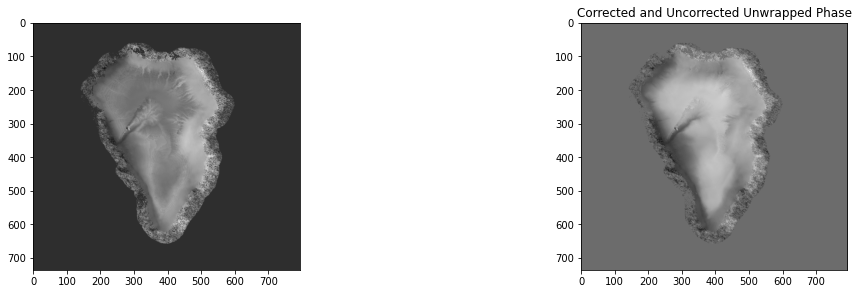

In [59]:
%matplotlib inline
corrected = gdal.Open(cor_paths[0])
uncorrected = gdal.Open(unc_paths[0])
im_c = corrected.GetRasterBand(1).ReadAsArray()
im_u = uncorrected.GetRasterBand(1).ReadAsArray()

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.imshow(im_c, cmap='gray')
ax2.imshow(im_u, cmap='gray')
plt.title('Corrected and Uncorrected Unwrapped Phase')

<font face='Calibri' size='3'><b>5.3.2 Plot a difference map of the two images</b></font>

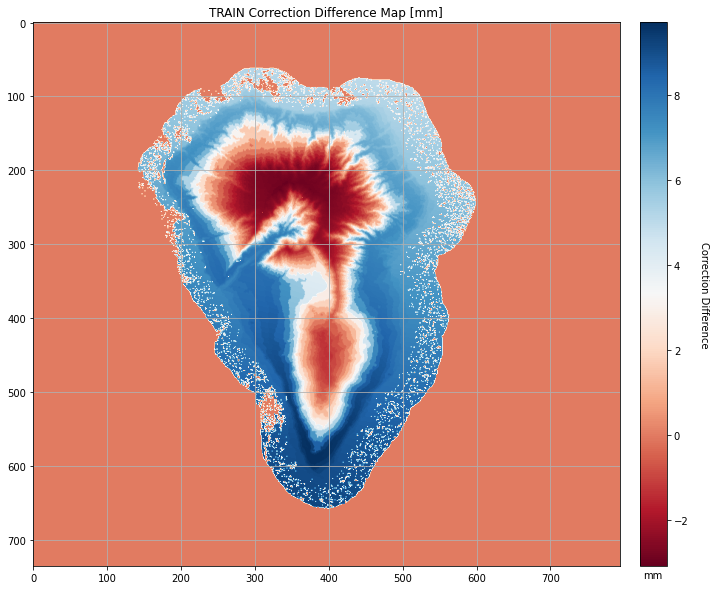

In [60]:
difference = np.subtract(im_c, im_u)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)
fig_plot = ax1.imshow(difference, cmap='RdBu')
cbar = fig.colorbar(fig_plot, fraction=0.24, pad=0.02)
cbar.ax.set_xlabel('mm')
cbar.ax.set_ylabel('Correction Difference', rotation=270, labelpad=20)
ax1.set(title='TRAIN Correction Difference Map [mm]')
plt.grid()

<font face='Calibri'><font size='3'>In looking at the Correction Difference Map, we can see that size of the correction correlates with surface elevation. Without this correction, a volcanologist would see the extra elevation difference as an indication of magma injection and possible eruptive activity.</font></font>
<br>

<font face='Calibri'><font size='4'><b>5.4 Convert back to original coordinate system</b></font>
<br>
<font size='3'>GIAnT requires the interferograms to be in a particular coordinate system. The original coordinate system is one of those accepted, so we will convert our interferograms back to that.
<br><br>
<b>5.4.0 Display our EPSGs</b>
</font>

In [61]:
print(f"original coordiante system = EPSG:{predominant_utm}")
print(f"TRAIN coordinate system =    EPSG:{coord_TRAIN}")

original coordiante system = EPSG:32627
TRAIN coordinate system =    EPSG:4326


<font face='Calibri' size='3'><b>5.4.1 Grab the paths to all the corrected tiffs</b></font>

In [62]:
paths = f"{corrected_folder}/*.tif"
tiff_paths = get_tiff_paths(paths)

# Uncomment to view paths
print_tiff_paths(tiff_paths)

Tiff paths:
ingram_subsets_converted/20210904_20210910_unw_phase_corrected.tif

ingram_subsets_converted/20210904_20210910_unw_phase.tif

ingram_subsets_converted/20210904_20210916_unw_phase_corrected.tif

ingram_subsets_converted/20210904_20210916_unw_phase.tif

ingram_subsets_converted/20210910_20210916_unw_phase_corrected.tif

ingram_subsets_converted/20210910_20210916_unw_phase.tif

ingram_subsets_converted/20210910_20210922_unw_phase_corrected.tif

ingram_subsets_converted/20210910_20210922_unw_phase.tif

ingram_subsets_converted/20210916_20210922_unw_phase_corrected.tif

ingram_subsets_converted/20210916_20210922_unw_phase.tif

ingram_subsets_converted/20210916_20210928_unw_phase_corrected.tif

ingram_subsets_converted/20210916_20210928_unw_phase.tif

ingram_subsets_converted/20210922_20210928_unw_phase_corrected.tif

ingram_subsets_converted/20210922_20210928_unw_phase.tif

ingram_subsets_converted/20210922_20211004_unw_phase.tif

ingram_subsets_converted/20210928_20211004_unw_p

<font face='Calibri' size='3'><b>5.4.2 check that the current coordinate system of the files is different from the desired.</b></font>

In [63]:
utm_zones, utm_types = get_utm_zones_types(tiff_paths)
print(f"Current UTM Types & Zones = EPSG:{list(set(utm_zones))}")
print(f"Expected current system   = EPSG:{coord_TRAIN}")
print(f"Desired coordinate system = EPSG:{predominant_utm}")

Checking UTM Zones in the data stack ...

Current UTM Types & Zones = EPSG:['4326']
Expected current system   = EPSG:4326
Desired coordinate system = EPSG:32627


<font face='Calibri' size='3'><b>5.4.3 Reproject the corrected tiffs.</b></font>

In [64]:
for file in tiff_paths:
    # Designate the output file and its path; ideally these are the same. 
    # GDAL can't do that (it'll overwrite data sometimes), so for each  
    # we create new file with the correct projection, delete the old file, 
    # and then rename the newly created file. 
    base_path ,filename = os.path.split(file)
    desig = 'TEMP_'
    outfile = os.path.join(base_path, f"{desig}{filename}")
    # create the convert command
    cmd = f"gdalwarp -t_srs EPSG:{predominant_utm} {file} {outfile}"
    !{cmd} # convert the file
    
    # delete the file in the EPSG:4326 coordinate system
    try:
        os.remove(file)
    except:
        pass
    
    # rename the file in the utm coordinate system to our original name of 'inFile'. 
    try:
        os.rename(outfile, file)
    except:
        pass

Creating output file that is 767P x 804L.
Processing ingram_subsets_converted/20210904_20210910_unw_phase_corrected.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 767P x 804L.
Processing ingram_subsets_converted/20210904_20210910_unw_phase.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ingram_subsets_converted/20210904_20210910_unw_phase.tif.
Copying nodata values from source ingram_subsets_converted/20210904_20210910_unw_phase.tif to destination ingram_subsets_converted/TEMP_20210904_20210910_unw_phase.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 767P x 804L.
Processing ingram_subsets_converted/20210904_20210916_unw_phase_corrected.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 767P x 804L.
Processing ingram_subsets_converted/20210904_20210916_unw_phase.tif [1/1] : 0Using internal nodata values (e.g. 0) for image i

<font face='Calibri' size='3'><b>5.4.4 Confirm that the files are now in the correct projection</b></font>

In [65]:
utm_zones, utm_types = get_utm_zones_types(tiff_paths)
print(f"Current UTM Types & Zones = EPSG:{list(set(utm_zones))}")
print(f"Expected current system   = EPSG:{predominant_utm}")
print(f"Desired coordinate system = EPSG:{predominant_utm}")

Checking UTM Zones in the data stack ...

Current UTM Types & Zones = EPSG:['32627']
Expected current system   = EPSG:32627
Desired coordinate system = EPSG:32627


<font face='Calibri'><font size='4'><b>5.5 Take care of some final details</b></font>
    <br><br>
<font size='3'><b>5.5.0 Do another pixel check</b></font>
<br>
<font size='3'>Check the pixel sizes again, and then do the pixel correction if necessary.
</font></font>

In [66]:
pixels_lines = get_pixels_lines(tiff_paths)
print(pixels_lines)
if len(pixels_lines['pixels']) == 1 and \
len(pixels_lines['lines']) == 1:
    print("All images in the stack have the same dimensions")
else:
    print("Error: Images with different dimensions exist in the stack")

{'pixels': {767}, 'lines': {804}}
All images in the stack have the same dimensions


<font face='Calibri' size='3'><b>5.5.1 Pickle the information we need to access in the Part 2 notebook</b></font>

In [67]:
print(to_pickle)
filename = 'part1_pickle'
outfile = open(filename,'wb')

pickle.dump(to_pickle, outfile)
outfile.close()

{'ingram_folder': 'ingrams', 'subset_folder': 'ingram_subsets', 'corrected_folder': 'ingram_subsets_converted', 'heading_avg': 192.62619544615384, 'utm': '32627'}


<font face='Calibri'><font size='3'>
You have now corrected the interferograms for atmospheric conditions and can proceed to Part 2: GIAnT. 
</font></font>
<br>
<font face='Calibri' size='3'><b>Print the path to the analysis directory, which you can copy/paste into Part 2</b></font>

In [68]:
print(analysis_directory)

/home/jovyan/GEOS_657_Labs/2019/test


<font face="Calibri" size="2"> <i>GEOS 657-Lab9-InSARTimeSeriesAnalysis-Part1-DataDownload-HyP3_v2.ipynb - Version 0.0. - May 2021
    </i>
</font>